<a href="https://colab.research.google.com/github/kate-simonova/cancer-subtyping/blob/main/01_ColorectalCancerSubtyping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # ML/DL based models for colorectal cancer subtype identification

This notebook is used to estimate the number of samples and genes in available colorectal cancer datasets. It mainly contains some preprocessing steps for the data.

**Keywords:** Subtyping, Cancer, Gene Expression, Tumor Microenvironment

**Data source:**  https://www.synapse.org/#!Synapse:syn2634742

## Data Loading and Preparation

In [3]:
!pip install biomart

In [4]:
# importing necessary packages

import os
import pandas as pd
import warnings
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from pandas.io.parsers.readers import read_csv
import functools as ft

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import scipy.stats as ss

path = "/home/simonova/Colorectal_cancer/"

In [5]:
%load_ext rpy2.ipython
# functions used in this script
def get_ensembl_mappings():
  """
  this function is used to call table for  HUGO gene ID to ENTREZ ID conversion
  """
  # Set up connection to server 
  import biomart
  from io import StringIO                                             
  server = biomart.BiomartServer('http://ensembl.org/biomart')         
  mart = server.datasets['hsapiens_gene_ensembl']                            
  # List the types of data we want                                            
  response = mart.search({'attributes':  ["affy_hg_u133_plus_2", "hgnc_symbol", "entrezgene_id"]})                          
  data = response.raw.data.decode('ascii')                                    
  
  df = pd.read_csv(StringIO(data), sep="\t", names=["Affymetrix", "Hugo", "Entrez"], header=0)
  df = df.dropna()
  df.Entrez = df.Entrez.astype("int")
  df = df.astype(object)                                                                                  
  return df

def merge_counts(counts_df, mapping_df, column, index_column, drop_col):
  """
  this function is mainly used for preprocessing of data (Gene IDs to Entrez ID)  
  """
  counts_df = pd.merge(counts_df, df, left_index=True, right_on = f"{column}", how="left")
  counts_df = counts_df.drop_duplicates(f"{index_column}")
  counts_df = counts_df.dropna()
  counts_df = counts_df.drop([f"{column}", f"{drop_col}"], axis=1)
  counts_df = counts_df.set_index(f"{index_column}")
  counts_df.index.name = f"{index_column}"
  counts_df = counts_df[~counts_df.index.duplicated()]
  counts_df = counts_df[counts_df.index != ""]
  counts_df.sort_index(inplace=True)
  return counts_df
 
def prepare_labels(df, GEO_ID):
  """
  this function is used to extract labels from a CRC consortium metadata
  """
  df = df[df["dataset"] == GEO_ID]
  df = df[["sample","CMS_network"]]
  df.reset_index()
  return df

def scale_pca(df):
  """
  this function is used to prepare data for visualization with PCA
  """
  X_scaled_df = StandardScaler().fit_transform(df)
  X_scaled_df = pd.DataFrame(X_scaled_df,columns=df.columns)

  pca = PCA()
  components = pca.fit_transform(X_scaled_df)
  labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }
  return (components, labels)


class FunctionalSpectra:
  """
  this class is used to convert genes to functional spectra
  """  
  def __init__(self):
    self.fs = None
  
  def fit(self, df, _):
    df = df.fillna(0)

    %R  -i df
    %R print("BEFORE")
    %R head(df)
    %R names(df) <- as.character(as.numeric(names(df)))
    %R fs <- getFunctionalSpectra(df)
    %R fs <- as.data.frame(fs)
    fs = %R fs

    self.fs = fs
    print("Called FunctionalSpectra")
    return fs
  
  def getLastTransform(self):
      return self.fs

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() 
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y + 20, value, ha="center")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [6]:
# loading manifest for conversion between gene/probeset ID and ENTREZ ID 
df = get_ensembl_mappings()
df.shape

(42043, 3)

In [7]:
# loading file that contains additional metadata about samples normalization and platform (microarray/sequencing)
annt_df = pd.read_csv(f"~/annotation.csv.zip", compression="zip")
annt_df = annt_df[annt_df["Cancer type"] == "CRC"]
annt_df.shape
d_ilmn = dict(annt_df[["ID", "Technology"]].values)
d_norm = dict(annt_df[["ID", "Normalization"]].values)
len(d_ilmn)

14

### GSE files

This script is used mainly to ckeck demensions and labels of the data.

In [8]:
# loading metdata 
label_geo_df = pd.DataFrame()
gse_count_df = pd.DataFrame() 
labels_df = pd.read_csv(f"{path}/labels_df.csv.zip", sep=";")

# loading counts
count = 0
for f in os.listdir(path):
  if f.startswith("GSE"):
    count += 1
    counts_df = pd.read_csv(f"{path}/{f}", index_col=0, sep="\t")
    label_gse_df = prepare_labels(labels_df, f.split("_", 1)[0].lower())
    counts_df.sort_index(inplace=True)
    new_names = counts_df.columns.tolist()
    if f.split("_", 1)[0] in ["GSE33113", "GSE23878", "GSE14333", "GSE2109", "GSE17536", "GSE13067", "GSE13294"]:
      new_names = [i.split(".")[0] for i in counts_df.columns.tolist()]
    if f.split("_", 1)[0] in ["GSE35896", "GSE20916", "GSE37892", "GSE39582"]:
      new_names = [i.split("_", 1)[0] for i in counts_df.columns.tolist()]
    counts_df.columns = new_names
    # new lines
    label_gse_df = label_gse_df[label_gse_df["sample"].isin(counts_df.columns)]
    counts_df = counts_df[label_gse_df["sample"].tolist()]
    label_geo_df = label_geo_df.append(label_gse_df)
    gse_count_df = gse_count_df.append(counts_df.T)
    print(count, f.split("_", 1)[0], "Shape - ", counts_df.shape, "Null - ", sum(counts_df.isna().sum()), "Labels - ", len(label_gse_df))

/tmp/ipykernel_15031/3562171096.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_geo_df = label_geo_df.append(label_gse_df)
/tmp/ipykernel_15031/3562171096.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gse_count_df = gse_count_df.append(counts_df.T)


1 GSE20916 Shape -  (54675, 45) Null -  0 Labels -  45


/tmp/ipykernel_15031/3562171096.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_geo_df = label_geo_df.append(label_gse_df)
/tmp/ipykernel_15031/3562171096.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gse_count_df = gse_count_df.append(counts_df.T)


2 GSE37892 Shape -  (54675, 107) Null -  0 Labels -  107


/tmp/ipykernel_15031/3562171096.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_geo_df = label_geo_df.append(label_gse_df)
/tmp/ipykernel_15031/3562171096.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gse_count_df = gse_count_df.append(counts_df.T)


3 GSE2109 Shape -  (54675, 244) Null -  0 Labels -  244


/tmp/ipykernel_15031/3562171096.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_geo_df = label_geo_df.append(label_gse_df)
/tmp/ipykernel_15031/3562171096.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gse_count_df = gse_count_df.append(counts_df.T)


4 GSE35896 Shape -  (54675, 51) Null -  0 Labels -  51


/tmp/ipykernel_15031/3562171096.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_geo_df = label_geo_df.append(label_gse_df)
/tmp/ipykernel_15031/3562171096.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gse_count_df = gse_count_df.append(counts_df.T)


5 GSE14333 Shape -  (54675, 129) Null -  0 Labels -  129


/tmp/ipykernel_15031/3562171096.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_geo_df = label_geo_df.append(label_gse_df)
/tmp/ipykernel_15031/3562171096.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gse_count_df = gse_count_df.append(counts_df.T)


6 GSE23878 Shape -  (54675, 24) Null -  0 Labels -  24


/tmp/ipykernel_15031/3562171096.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_geo_df = label_geo_df.append(label_gse_df)
/tmp/ipykernel_15031/3562171096.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gse_count_df = gse_count_df.append(counts_df.T)


7 GSE13067 Shape -  (54675, 57) Null -  0 Labels -  57


/tmp/ipykernel_15031/3562171096.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_geo_df = label_geo_df.append(label_gse_df)
/tmp/ipykernel_15031/3562171096.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gse_count_df = gse_count_df.append(counts_df.T)


8 GSE13294 Shape -  (54675, 124) Null -  0 Labels -  124


/tmp/ipykernel_15031/3562171096.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_geo_df = label_geo_df.append(label_gse_df)
/tmp/ipykernel_15031/3562171096.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gse_count_df = gse_count_df.append(counts_df.T)


9 GSE33113 Shape -  (54675, 80) Null -  0 Labels -  80


/tmp/ipykernel_15031/3562171096.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_geo_df = label_geo_df.append(label_gse_df)
/tmp/ipykernel_15031/3562171096.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gse_count_df = gse_count_df.append(counts_df.T)


10 GSE17536 Shape -  (54675, 147) Null -  0 Labels -  147


/tmp/ipykernel_15031/3562171096.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_geo_df = label_geo_df.append(label_gse_df)
/tmp/ipykernel_15031/3562171096.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gse_count_df = gse_count_df.append(counts_df.T)


11 GSE39582 Shape -  (54675, 466) Null -  0 Labels -  466


From above we can see that for some datasets we have less labels that actual columns in count matrix (GSE14333, GSE20916, GSE23878, GSE33113).

In [9]:
# GEO counts combined
gse_count_df.shape

(1474, 54675)

In [10]:
gse_count_df.head()

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at
GSM523257,8.572773,6.470604,5.401972,7.947478,3.597008,6.973230,5.504064,4.296573,6.344399,3.402507,...,7.504675,8.015917,8.053368,7.969537,9.271270,8.986578,11.168573,10.777351,13.116794,12.887055
GSM523258,8.560298,6.631615,5.419189,8.023038,3.580193,7.244542,5.476099,4.102657,6.190113,3.405965,...,7.810606,7.933129,8.006717,7.878891,9.167901,8.908862,11.209053,10.780847,13.091021,12.860453
GSM523262,8.706470,6.518971,5.235054,7.905218,3.392388,7.164432,6.238621,3.994024,6.462694,3.342968,...,7.269668,8.036403,8.211907,8.063824,9.374794,9.139417,11.338422,10.966705,13.282356,13.108210
GSM523263,8.541094,6.842851,5.272680,8.053485,3.578088,7.259270,5.466456,3.906749,6.626795,3.460672,...,7.827678,7.945589,8.018416,8.031744,9.250425,8.988519,11.230908,10.836492,13.146017,12.954265
GSM523278,8.609210,6.267143,5.598432,8.078592,3.351915,7.056472,5.444248,4.089265,6.137440,3.466433,...,7.278470,8.614782,8.636329,8.560038,9.840638,9.657369,11.882801,11.581348,13.555514,13.384964


In [11]:
# conversion of genes to ENTREZ ID
gse_count_df = merge_counts(gse_count_df.T, df, "Affymetrix", "Entrez", "Hugo")
gse_count_df.shape

(20319, 1474)

In [12]:
label_geo_df.groupby("CMS_network")["sample"].count().sum()

1474

In [13]:
round(label_geo_df["CMS_network"].value_counts(normalize=True)*100,2)

CMS2    42.81
CMS4    25.03
CMS1    19.06
CMS3    13.09
Name: CMS_network, dtype: float64

In [14]:
#gse_count_df.to_csv(f"{path}/all_preprocessed/X_GEO.csv.tar.gz", compression = "gzip")
#label_geo_df.to_csv(f"{path}/all_preprocessed/y_GEO.csv.tar.gz", compression = "gzip")

### TCGA

In [15]:
# counts
counts_tcga_df = pd.read_csv(f"{path}/TCGACRC_expression.zip",index_col=0, sep="\t")
counts_tcga_df = merge_counts(counts_tcga_df, df, "Hugo", "Entrez", "Affymetrix")
counts_tcga_df.head()

,TCGA-AA-A01I,TCGA-AA-3684,TCGA-AA-A004,TCGA-AA-3680,TCGA-A6-2670,TCGA-AA-3870,TCGA-AA-3560,TCGA-AA-3811,TCGA-AA-A00O,TCGA-AA-3862,...,TCGA-AG-A036,TCGA-AG-3584,TCGA-AG-3608,TCGA-AG-3893,TCGA-AG-3898,TCGA-AG-A016,TCGA-AG-3887,TCGA-AG-3581,TCGA-AG-A00C,TCGA-AG-3594
Entrez,,,,,,,,,,,,,,,,,,,,,
1,2.894527,7.176489,7.477758,5.097725,4.683214,5.546567,1.421102,5.500337,4.852473,4.471604,...,4.222488,5.225414,5.790561,4.788999,5.079826,2.879451,5.087246,4.880627,3.844647,5.025742
2,11.258449,13.757572,11.514714,12.722776,12.290497,12.730804,13.111064,12.548544,13.874176,11.354735,...,12.188519,12.549204,11.626870,12.790620,12.183902,11.213609,11.878715,12.398589,10.453220,11.885535
9,8.150691,7.231257,5.672425,8.004014,7.963920,6.513737,7.413316,7.026645,6.789226,7.675179,...,6.475074,7.276913,7.586068,7.568750,7.807850,6.440236,8.117122,7.820521,7.550833,7.690262
10,7.939988,6.090942,0.000000,8.068473,8.298901,4.023096,5.424462,5.556203,5.146505,6.600585,...,4.573150,5.295087,7.578534,6.915413,7.274692,6.239219,8.557021,7.418684,7.562178,6.565547
12,7.742936,8.603848,10.199672,6.456177,4.953377,6.357304,10.425385,6.818162,4.323493,7.340000,...,6.365339,4.747022,6.943617,5.470657,5.519536,4.560024,8.168933,8.250586,3.982081,6.804210


In [16]:
counts_tcga_df.shape

(16039, 263)

In [17]:
sum(counts_tcga_df.isna().sum())

0

In [18]:
label_tcga_df = prepare_labels(labels_df, "tcga") 
len(label_tcga_df)

459

In [19]:
label_tcga_df = label_tcga_df[label_tcga_df["sample"].isin(counts_tcga_df.columns)]
label_tcga_df.shape

(207, 2)

In [20]:
counts_tcga_df = counts_tcga_df[label_tcga_df["sample"].tolist()]
counts_tcga_df.shape

(16039, 207)

In [21]:
#counts_tcga_df.to_csv(f"{path}/all_preprocessed/X_TCGA.csv.tar.gz", compression = "gzip")
#label_tcga_df.to_csv(f"{path}/all_preprocessed/y_tcga.csv.tar.gz", compression = "gzip")

### PETACC3

In [22]:
# conversion of probeset to ENTREZ ID
helper_df = pd.read_csv(f"{path}/A-AFFY-101.adf.txt.zip", sep="\t", skiprows=12)
helper_df = helper_df[["Composite Element Name",'Composite Element Database Entry[locus]']]
helper_df.columns = ["Hybridization REF", "entrezgene_id"]
helper_df.shape

(61528, 2)

In [23]:
# counts
counts_petacc3_df = pd.read_csv(f"{path}/PETACC3_expression.zip", sep="\t")
counts_petacc3_df.index.name = ""
counts_petacc3_df.head()

,Hybridization REF,PETACC3-0244,PETACC3-0268,PETACC3-0180,PETACC3-0596,PETACC3-0411,PETACC3-0284,PETACC3-0546,PETACC3-0501,PETACC3-0641,...,PETACC3-0460,PETACC3-0044,PETACC3-0045,PETACC3-0046,PETACC3-0430,PETACC3-0432,PETACC3-0431,PETACC3-0429,PETACC3-0426,PETACC3-0425
,,,,,,,,,,,,,,,,,,,,,
0,AFFX-BioB-5_at,11.38667,11.38643,11.08049,11.57510,11.52646,10.47507,10.80688,10.49251,10.94935,...,10.99508,8.48762,9.24470,9.14039,9.54746,9.91186,9.42792,8.62841,9.13921,8.10552
1,AFFX-BioB-M_at,11.99590,12.19502,11.97303,12.22600,12.24482,11.40561,11.72135,11.33827,11.66504,...,11.84584,9.62379,10.28222,10.07574,10.47987,10.76339,10.45566,9.51636,10.21202,9.06640
2,AFFX-BioB-3_at,12.15398,12.31590,12.18325,12.31942,12.42399,11.62715,11.84672,11.56346,11.86210,...,11.99931,9.89974,10.47548,10.38875,10.75418,10.88921,10.68703,9.86565,10.69220,9.37538
3,AFFX-BioC-5_at,12.61940,12.78452,12.64269,12.81759,12.87965,11.96849,12.26492,12.03619,12.36589,...,12.38901,10.68859,11.15133,11.01555,11.25224,11.59389,11.24138,10.89544,11.51985,10.26557
4,AFFX-BioC-3_at,12.44868,12.63752,12.38745,12.63761,12.63451,11.73705,11.90883,11.70874,12.11987,...,12.08058,10.11868,10.79183,10.52076,10.80610,11.28438,10.87807,10.43286,11.19916,9.80726


In [24]:
counts_petacc3_df.shape

(61528, 689)

In [25]:
helper_df = helper_df.dropna()
helper_df.shape

(49998, 2)

In [26]:
counts_petacc3_df = helper_df.merge(counts_petacc3_df, how="left", on="Hybridization REF")
counts_petacc3_df = counts_petacc3_df[counts_petacc3_df['entrezgene_id'].notna()]
counts_petacc3_df = counts_petacc3_df.drop_duplicates(subset = "entrezgene_id")
counts_petacc3_df.shape

(15842, 690)

In [27]:
counts_petacc3_df = counts_petacc3_df.set_index("entrezgene_id")
counts_petacc3_df = counts_petacc3_df.drop("Hybridization REF", axis=1)
counts_petacc3_df.sort_index(inplace=True)

In [28]:
sum(counts_petacc3_df.isna().sum())

0

In [29]:
label_petacc3_df = prepare_labels(labels_df, "petacc3") 
len(label_petacc3_df)

526

In [30]:
label_petacc3_df = label_petacc3_df[label_petacc3_df["sample"].isin(counts_petacc3_df.columns)]
label_petacc3_df.shape

(526, 2)

In [31]:
counts_petacc3_df = counts_petacc3_df[label_petacc3_df["sample"].tolist()]
counts_petacc3_df.sort_index(inplace=True)
counts_petacc3_df.shape

(15842, 526)

In [32]:
#counts_petacc3_df.to_csv(f"{path}/all_preprocessed/X_petacc3.csv.tar.gz", compression = "gzip")
#label_petacc3_df.to_csv(f"{path}/all_preprocessed/y_petacc3.csv.tar.gz", compression = "gzip")

### KFSYSCC

In [33]:
# counts
counts_kfsyscc_df = pd.read_csv(f"{path}/KFSYSCC_frma_expression.zip",index_col=0, sep="\t")
counts_kfsyscc_df.tail()

,COLON001.CEL,COLON002.CEL,COLON003.CEL,COLON004.CEL,COLON005.CEL,COLON006.CEL,COLON007.CEL,COLON008.CEL,COLON009.CEL,COLON010.CEL,...,COLON313.CEL,COLON314.CEL,COLON315.CEL,COLON316.CEL,COLON317.CEL,COLON318.CEL,COLON319.CEL,COLON320.CEL,COLON321.CEL,COLON322.CEL
AFFX-ThrX-5_at,7.558619,7.178968,7.156833,7.357738,7.022129,7.150997,7.122412,6.743170,6.705053,5.947729,...,3.920977,3.860761,3.788049,3.858415,3.841573,3.837027,3.822057,3.885153,3.759881,3.837064
AFFX-ThrX-M_at,7.793918,7.340630,7.494361,7.702025,6.962394,7.421895,7.288007,6.851420,6.862310,6.533331,...,3.620869,3.739304,3.510777,3.677875,3.738445,3.578325,3.535462,3.615400,3.280481,3.320071
AFFX-TrpnX-3_at,2.935507,2.952419,3.011267,3.013891,2.939097,2.933068,3.051066,3.036861,3.075843,2.907919,...,2.933542,3.067728,3.010462,2.939699,2.946448,2.936388,2.854226,2.992363,2.904654,2.989783
AFFX-TrpnX-5_at,3.438793,3.477349,3.400292,3.431387,3.426369,3.478599,3.224925,3.566977,3.380028,3.416253,...,3.420893,3.401328,3.457940,3.400251,3.329452,3.388530,3.267368,3.348000,3.292682,3.460105
AFFX-TrpnX-M_at,3.333143,3.361064,3.252660,3.237155,3.377685,3.443339,3.578731,3.289461,3.546598,3.315596,...,3.132170,3.141046,3.261173,3.196077,3.164372,3.127216,3.101915,3.272628,3.126534,3.246091


In [34]:
counts_kfsyscc_df = merge_counts(counts_kfsyscc_df, df, "Affymetrix", "Entrez", "Hugo")
counts_kfsyscc_df.shape

(20319, 322)

In [35]:
counts_kfsyscc_df.isna().sum().sum()

0

In [36]:
new_names = [i.split(".")[0] for i in counts_kfsyscc_df.columns.tolist()]
counts_kfsyscc_df.columns = new_names

['COLON002', 'COLON003', 'COLON004', 'COLON005']

In [38]:
label_kfsyscc_df = prepare_labels(labels_df, "kfsyscc")
len(label_kfsyscc_df)

229

In [39]:
label_kfsyscc_df = label_kfsyscc_df[label_kfsyscc_df["sample"].isin(counts_kfsyscc_df.columns)]
label_kfsyscc_df.shape

(229, 2)

In [40]:
counts_kfsyscc_df = counts_kfsyscc_df[label_kfsyscc_df["sample"].tolist()]
counts_kfsyscc_df.shape

(20319, 229)

In [41]:
#counts_kfsyscc_df.to_csv(f"{path}/all_preprocessed/X_kfsyscc.csv.tar.gz", compression = "gzip")
#label_kfsyscc_df.to_csv(f"{path}/all_preprocessed/y_kfsyscc.csv.tar.gz", compression = "gzip")

## All metadata labels

In [42]:
final_labels_df = pd.concat([label_geo_df, label_tcga_df, label_petacc3_df, label_kfsyscc_df])
final_labels_df = final_labels_df[final_labels_df["CMS_network"]!="UNK"]
final_labels_df.shape

(2436, 2)

In [44]:
final_labels_df.groupby("CMS_network")["sample"].count()

CMS_network
CMS1     420
CMS2    1060
CMS3     324
CMS4     632
Name: sample, dtype: int64

## Merged count matrices

In [45]:
print("GSE", gse_count_df.axes[0].tolist()[:5])
print("TCGA", counts_tcga_df.axes[0].tolist()[:5])
print("PATACC3", counts_petacc3_df.axes[0].tolist()[:5])
print("KFSYSCC", counts_kfsyscc_df.axes[0].tolist()[:5])

GSE [1, 2, 9, 10, 12]
TCGA [1, 2, 9, 10, 12]
PATACC3 [2.0, 9.0, 10.0, 12.0, 13.0]
KFSYSCC [1, 2, 9, 10, 12]


In [46]:
print("GSE", gse_count_df.shape)
print("TCGA", counts_tcga_df.shape)
print("PATACC3", counts_petacc3_df.shape)
print("KFSYSCC", counts_kfsyscc_df.shape)

GSE (20319, 1474)
TCGA (16039, 207)
PATACC3 (15842, 526)
KFSYSCC (20319, 229)


In [47]:
dfs = [gse_count_df, counts_tcga_df, counts_petacc3_df, counts_kfsyscc_df]

merged_df = ft.reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how="left"), dfs)
merged_df.shape 

(20319, 2436)

In [48]:
merged_df.head()

,GSM523257,GSM523258,GSM523262,GSM523263,GSM523278,GSM523283,GSM523284,GSM523285,GSM523292,GSM523293,...,COLON309,COLON311,COLON313,COLON314,COLON315,COLON316,COLON317,COLON318,COLON319,COLON320
Entrez,,,,,,,,,,,,,,,,,,,,,
1.0,5.060097,5.184475,5.251561,5.087730,5.093896,5.334089,5.978312,5.431407,5.191975,5.237459,...,4.989832,4.907673,5.183565,4.790792,4.820070,4.754985,4.898522,4.784457,5.410652,4.942731
2.0,8.743515,8.345401,8.275760,8.507785,8.781478,9.733426,10.063037,11.248269,10.576267,10.834294,...,9.391704,10.184089,10.980469,9.568281,9.378937,10.491481,10.031182,9.943199,12.086362,10.119649
9.0,9.617134,9.547308,9.453139,9.453850,9.481092,10.246476,7.944206,7.696543,8.463840,9.707451,...,7.226549,8.344495,8.239053,8.932637,6.560102,8.178757,7.328830,7.837315,7.079545,6.590414
10.0,7.575808,7.848294,7.575652,7.610295,7.531804,8.287021,6.695803,6.859816,8.444554,9.399262,...,5.685227,7.517797,6.469289,5.582934,5.631502,7.067459,6.528703,6.707653,5.431990,6.102285
12.0,8.174738,7.611538,8.404678,7.733101,7.890432,6.045923,6.451081,5.873736,8.237725,7.478175,...,5.562609,4.903011,7.207645,7.689768,4.846879,5.535309,5.431958,5.581735,7.555045,5.433386


In [49]:
merged_df = merged_df[final_labels_df["sample"].tolist()]
merged_df.shape

(20319, 2436)

## Number of samples per subtype

/tmp/ipykernel_15031/1076069184.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(i)) for i in ax.get_yticks()], fontsize=16)


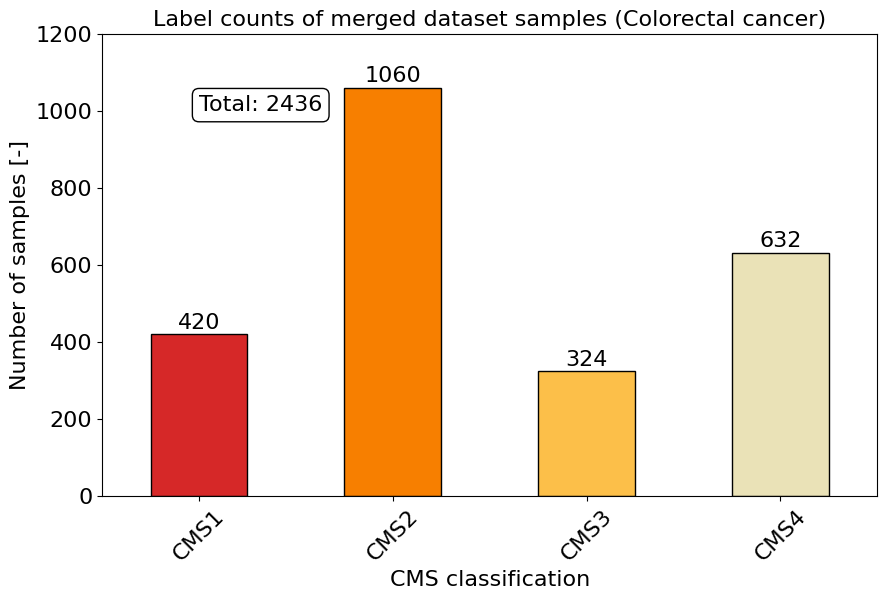

In [50]:
colors = ["#d62828", "#f77f00", "#fcbf49", "#eae2b7"]


frequencies = final_labels_df.groupby('CMS_network')["sample"].count().tolist()
freq_series = pd.Series(frequencies)
x_labels = final_labels_df.groupby('CMS_network')["sample"].count().index.tolist()

plt.figure(figsize=(10, 6))
ax = freq_series.plot(kind="bar", color=colors, edgecolor='black')
ax.set_title("Label counts of merged dataset samples (Colorectal cancer)", fontsize=16)
ax.set_xlabel("CMS classification", fontsize=16)
ax.set_ylim(0, 1200)
ax.set_ylabel("Number of samples [-]", fontsize=16)
ax.set_xticklabels(x_labels, fontsize=16, rotation=45)
ax.set_yticklabels([str(int(i)) for i in ax.get_yticks()], fontsize=16)

rects = ax.patches

for rect, label in zip(rects, x_labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, height, ha="center", va="bottom", fontsize=16,
    )
ax.text(0, 1000, f"Total: {final_labels_df.shape[0]}",fontsize=16, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
plt.savefig(f"{path}/img/colorectal_labels.pdf", format="pdf")
plt.show()

# Data Exploration & Feature selection

In [51]:
merged_df.shape

(20319, 2436)

In [52]:
merged_df.isna().sum().sum()

4060896

In [53]:
merged_df = merged_df.fillna(0) 
merged_df.isna().sum().sum()

0

In [54]:
%%script false --no-raise-error
final_labels_df.to_csv(f"{path}/merged/final_labels_df.csv.zip", index=False)
merged_df.to_csv(f"{path}/merged/merged_final_df.csv.zip", compression="zip")

# PCA (genes)

In the previos step, I saved data to dfs not to run the whole notebook again.

In [55]:
final_labels_df.shape

(2436, 2)

In [56]:
merged_df.isna().sum().sum()

0

In [57]:
merged_df.shape

(20319, 2436)

In [58]:
labels_df = labels_df[["sample", "CMS_network", "dataset"]]
labels_df = labels_df[labels_df["sample"].isin(merged_df.columns.tolist())]

In [59]:
labels_df.columns = ["Sample", "Label", "Dataset"]
labels_df["Platform"] = labels_df["Dataset"].apply(str.upper).map(d_ilmn)
labels_df["Normalization"] = labels_df["Dataset"].apply(str.upper).map(d_norm)
labels_df.head()

,Sample,Label,Dataset,Platform,Normalization
0,GSM820048,CMS2,gse33113,Affymetrix HG133plus2,fRMA
1,GSM820049,CMS2,gse33113,Affymetrix HG133plus2,fRMA
2,GSM820050,CMS1,gse33113,Affymetrix HG133plus2,fRMA
3,GSM820051,CMS1,gse33113,Affymetrix HG133plus2,fRMA
4,GSM820052,CMS2,gse33113,Affymetrix HG133plus2,fRMA


In [60]:
labels_df.groupby("Platform")["Label"].count()

Platform
Affymetrix HG133plus2       1703
Almac's Affymetrix Array     526
RNA sequencing               207
Name: Label, dtype: int64

In [61]:
labels_df.groupby("Normalization")["Label"].count()

Normalization
RMA      244
RSEM     207
fRMA    1985
Name: Label, dtype: int64

In [62]:
merged_df = merged_df[labels_df["Sample"]]

In [63]:
comp, labels = scale_pca(merged_df.T)

Outlier is KFSYSCC.

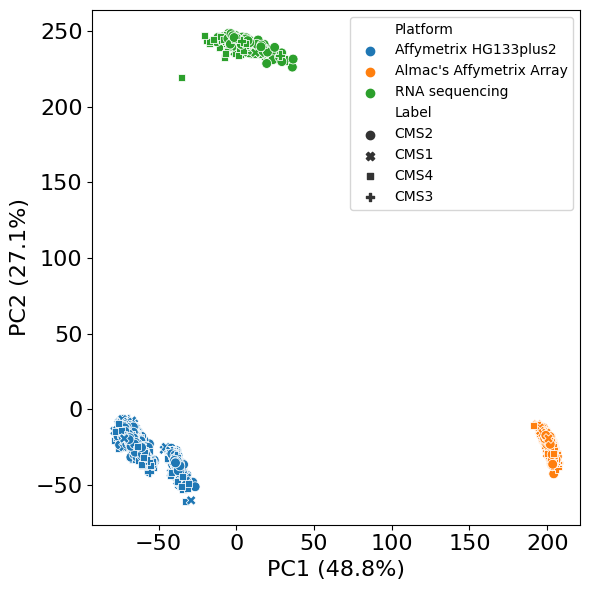

In [64]:
plt.figure(figsize=(6,6))
components_df = pd.DataFrame(comp)
components_df.columns = [f"PC{i+1}" for i in components_df.columns]
components_df.index = labels_df["Sample"]
c_df = pd.merge(components_df, labels_df, left_index=True, right_on="Sample", how="left")
#c_df
sns.scatterplot(x="PC1", y="PC2", s=50, hue="Platform", style="Label", data=c_df, )#legend=None
plt.xlabel("PC1 (48.8%)", fontsize=16)
plt.ylabel("PC2 (27.1%)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size': 10}, ncol=1)

plt.tight_layout()
plt.savefig(f"{path}/img/colorecctal_before_DeepCC.pdf", format="pdf")
plt.show()

In [65]:
labels_df

,Sample,Label,Dataset,Platform,Normalization
0,GSM820048,CMS2,gse33113,Affymetrix HG133plus2,fRMA
1,GSM820049,CMS2,gse33113,Affymetrix HG133plus2,fRMA
2,GSM820050,CMS1,gse33113,Affymetrix HG133plus2,fRMA
3,GSM820051,CMS1,gse33113,Affymetrix HG133plus2,fRMA
4,GSM820052,CMS2,gse33113,Affymetrix HG133plus2,fRMA
...,...,...,...,...,...
2682,TCGA-AG-3898,CMS4,tcga,RNA sequencing,RSEM
2684,TCGA-AG-A016,CMS2,tcga,RNA sequencing,RSEM
2685,TCGA-AG-3581,CMS2,tcga,RNA sequencing,RSEM
2686,TCGA-AG-A00C,CMS2,tcga,RNA sequencing,RSEM


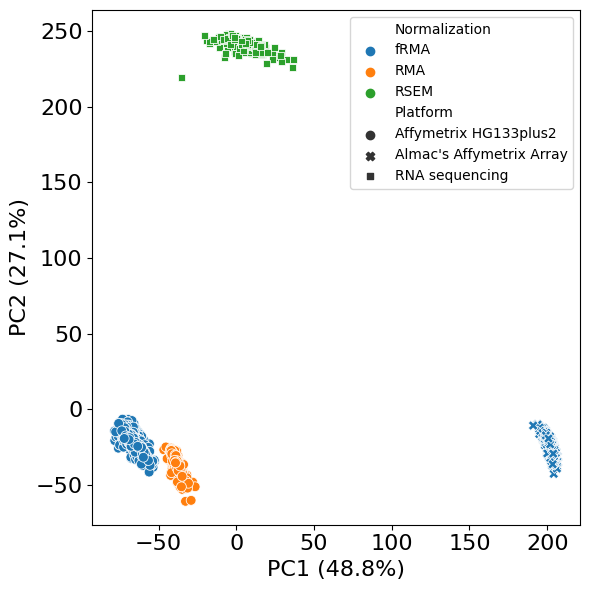

In [66]:
plt.figure(figsize=(6,6))
components_df = pd.DataFrame(comp)
components_df.columns = [f"PC{i+1}" for i in components_df.columns]
components_df.index = labels_df["Sample"]
c_df = pd.merge(components_df, labels_df, left_index=True, right_on="Sample", how="left")
#c_df
sns.scatterplot(x="PC1", y="PC2", s=50, hue="Normalization", style="Platform", data=c_df, )#legend=None  size="Label"
plt.xlabel("PC1 (48.8%)", fontsize=16)
plt.ylabel("PC2 (27.1%)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size': 10}, ncol=1)

plt.tight_layout()
plt.savefig(f"{path}/img/colorecctaldd_before_DeepCC_norm.pdf", format="pdf")
plt.show()

The problem what was observed is that different method Affymetrix Array, Agilent Array and RNAseq bring technical variability that is hgher than variability in subtypes (upper graph). In order to overcome the issue the data will be trandfermed to a functional spectrum, and then used for train_test_split and modeling.

# Functional spectra conversion

In [ ]:
%load_ext rpy2.ipython
%R install.packages("remote")
%R remotes::install_github("CityUHK-CompBio/DeepCC")
%R library(DeepCC)

In [ ]:
%%script false --no-raise-error 
count = 0

pipe = make_pipeline(FunctionalSpectra())

final_crc_df = pd.DataFrame()

for f in os.listdir(f"{path}/all_preprocessed/"):
  if f.endswith(".tar.gz") and f.startswith("X"):
    count += 1
    geo_name = f.split("_")[1]
    tdf = pd.read_csv(f"{path}/all_preprocessed/{f}", index_col=0, compression="gzip")
    tdf = tdf[~tdf.index.duplicated(keep='first')]
    tdf.index.name = ""
    tdf.index = tdf.index.astype("int")
    tdf = tdf.T
    #print(pd.DataFrame(tdf))
    fs = pipe.fit(tdf, _)
    final_crc_df = final_crc_df.append(fs.named_steps['functionalspectra'].getLastTransform())
    print(count, geo_name, "final_crc_df shape", final_crc_df.shape)

final_crc_df.to_csv(f"{path}/FS/crc_fs_final.csv.zip", compression="zip", index=True) 
labels_df.to_csv(f"{path}/FS/crc_metadata.csv.zip", compression="zip", index=True) 

# PCA (functional spectra)

In [ ]:
final_crc_df = pd.read_csv(f"{path}/FS/crc_fs_final.csv.zip", compression="zip", index_col=0) 
final_crc_df = final_crc_df.reindex(labels_df["Sample"])

In [ ]:
comp, labels = scale_pca(final_crc_df)

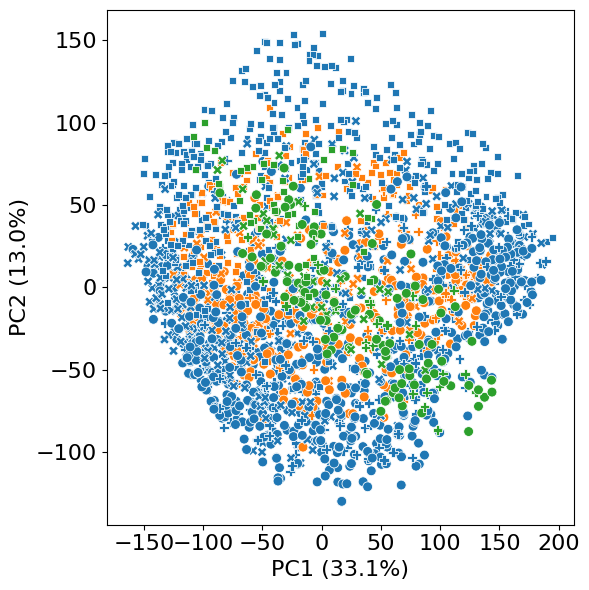

In [ ]:
plt.figure(figsize=(6,6))
components_df = pd.DataFrame(comp)
components_df.columns = [f"PC{i+1}" for i in components_df.columns]
components_df.index = labels_df["Sample"]
c_df = pd.merge(components_df, labels_df, left_index=True, right_on="Sample", how="left")
sns.scatterplot(x="PC1", y="PC2", s=50, hue="Platform", style="Label", data=c_df, legend=None)
plt.xlabel("PC1 (33.1%)", fontsize=16)
plt.ylabel("PC2 (13.0%)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(prop={'size': 12})
plt.tight_layout()
plt.savefig(f"{path}/img/colorectal_after_DeepCC.pdf", format="pdf")
plt.show()

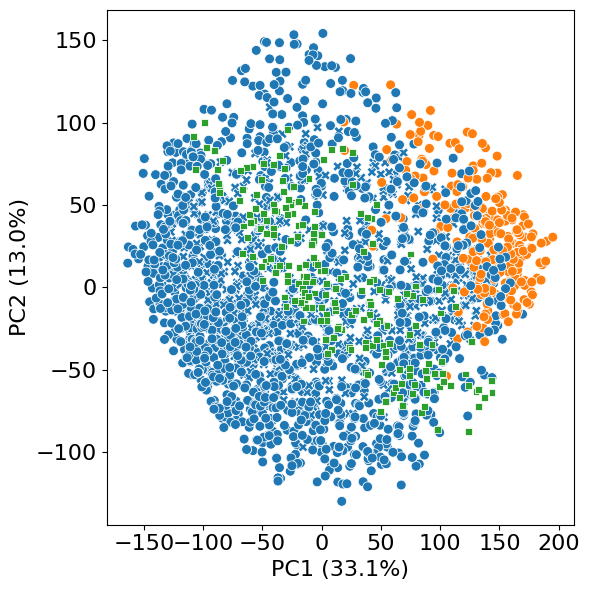

In [ ]:
plt.figure(figsize=(6,6))
components_df = pd.DataFrame(comp)
components_df.columns = [f"PC{i+1}" for i in components_df.columns]
components_df.index = labels_df["Sample"]
c_df = pd.merge(components_df, labels_df, left_index=True, right_on="Sample", how="left")
sns.scatterplot(x="PC1", y="PC2", s=50, hue="Normalization", style="Platform", data=c_df, legend=None)
plt.xlabel("PC1 (33.1%)", fontsize=16)
plt.ylabel("PC2 (13.0%)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(prop={'size': 12})
plt.tight_layout()
plt.savefig(f"{path}/img/colorectal_after_DeepCC_norm.pdf", format="pdf")
plt.show()

# Session info

In [ ]:
import matplotlib
import sklearn
import biomart
import scipy
import plotly
import google.colab

print("Pandas", pd.__version__)
print("Numpy", np.__version__)
print("Matplotlib", matplotlib.__version__)
print("Seaborn", sns.__version__)
print("plotly", plotly.__version__)
print("scipy", scipy.__version__)
print("colab", google.colab.__version__)
print("sklearn", sklearn.__version__)